In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, ISN_coeff
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable, get_Fano, get_stddev_sigma
from epi.util import plot_T_x


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"

In [2]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
ind = 62
W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

sigma_eps = Parameter("sigma_eps", 4, 
                      lb=0.*np.ones(4,), 
                      ub=0.005*np.ones(4,))
parameters = [sigma_eps]

# Define model
name = "SSSN"
model = Model(name, parameters)

lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])
print(lb, ub)


[0. 0. 0. 0.] [0.005 0.005 0.005 0.005]


In [4]:
D = sum([param.D for param in model.parameters])
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, mean, std):
    inds = np.logical_and(mean -2*std < T_x[:,0], 
                          T_x[:,0] < mean + 2*std)
    return inds

accept_mean = 5.
#accept_means = [0.]
accept_std = 1.

dt = 0.0005
T = 200
N = 50
c = 0.5

num_keep = 400
alphas = ['E']
num_alphas = len(alphas)
num_plot = num_keep
M = 1000
zs = []
T_xs = []
#cs = {'P':0.2857276499271393, 'S':0.45115533471107483}
#cs = {'P':0.28338050842285156, 'S':0.4607696533203125}
for i, alpha in enumerate(alphas):
    name = ""
    neuron_ind = neuron_inds[alpha]
    fontsize = 30

    _h = hb[None,:] + c*hc[None,:]
    stddev = get_stddev_sigma(alpha, W_mat, _h, N=100, dt=0.0005, T=T, T_ss=(T-50), mu=0.01)
    model.set_eps(stddev)

    num_found = 0
    z = None
    T_x = None
    count = 0
    while (num_found < num_keep):
        count += 1
        _z = np.zeros((M, D))
        for d in range(D):
            _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
        _T_x = model.eps(_z).numpy()
        print(np.mean(_T_x, axis=0))
        print(np.max(_T_x, axis=0))
        print(np.min(_T_x, axis=0))

        inds = accept_inds(_T_x, accept_mean, accept_std)
        _z = _z[inds, :]
        _T_x = _T_x[inds, :]
        num_found += _z.shape[0]

        if (z is None):
            z = _z
            T_x = _T_x
        else:
            z = np.concatenate((z, _z), axis=0)
            T_x = np.concatenate((T_x, _T_x), axis=0)
        print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

    num_found = z.shape[0]

    # reduce to num_keep
    z = z[:num_keep]
    T_x = T_x[:num_keep]
    zs.append(z)
    T_xs.append(T_x)

[ 12.861146 201.36005 ]
[ 31.162449 970.47504 ]
[0.6956985  0.47018245]
[ 13.107392 208.78435 ]
[  31.99655 1023.13934]
[0.621892  0.3744118]
[ 12.9685335 202.28056  ]
[ 28.80355 829.06854]
[1.2642192 1.5730658]


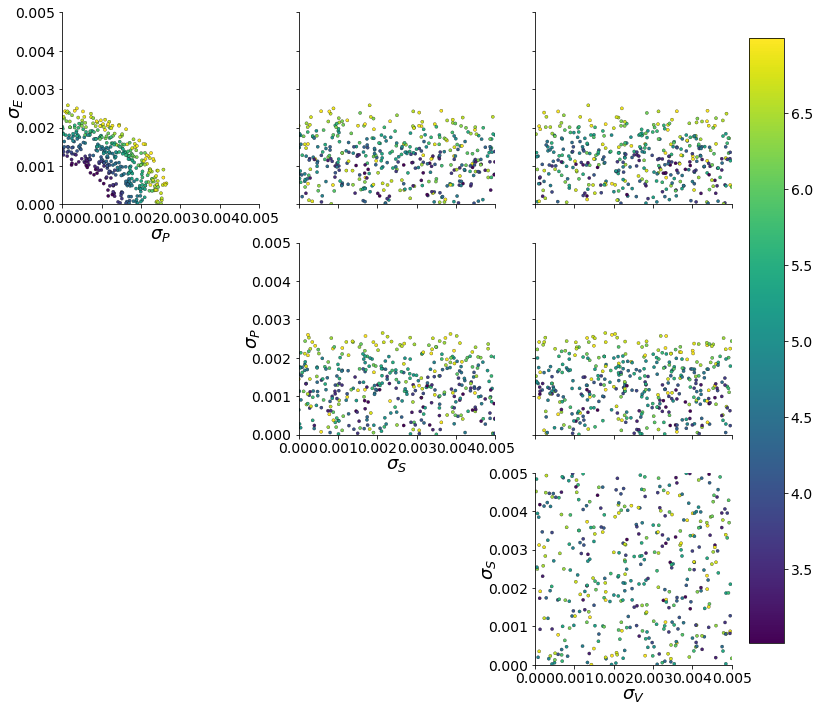

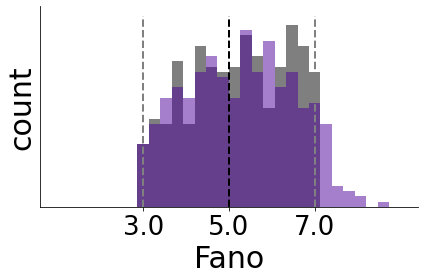

In [5]:
z_labels = [r'$\sigma_E$', r'$\sigma_P$', r'$\sigma_S$', r'$\sigma_V$']
fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(12,12),
               c=T_x[:num_plot,0],
               fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
#plt.savefig(figdir + name + '_z.png')

T_x_sim = model.eps(z).numpy()

plot_T_x(T_x[:,0], T_x_sim[:,0], x_mean=accept_mean, x_std=accept_std, 
         xlabel='Fano', fontsize=30)
plt.tight_layout()
#plt.savefig(figdir + name + '_Tx.png')

In [14]:
sigma_eps = np.random.uniform(-1., 1., (10,4))
print(sigma_eps)
Sigma = tf.linalg.diag(sigma_eps, padding)
print(Sigma.shape)


[[ 0.26496761 -0.621325   -0.72424881 -0.83607832]
 [-0.22512827  0.8469792  -0.56460201  0.78121718]
 [ 0.61947078 -0.12478651  0.62060212 -0.96143197]
 [-0.85380614 -0.94984865  0.56337567  0.93004699]
 [ 0.90007123 -0.18309536  0.33281513  0.99107645]
 [ 0.21719992  0.76652633  0.07299259 -0.69255911]
 [ 0.63865523 -0.79544602 -0.32055227 -0.49900098]
 [ 0.45829939 -0.98234847 -0.03217436  0.87150582]
 [ 0.02231399 -0.56491405 -0.04234429 -0.97811415]
 [ 0.424153    0.82642624 -0.7549334  -0.33408168]]
(10, 4, 4)
